In [92]:
# Course : CS 513 - Knowledge Discovery and Data Mining
# Group Members: Branden Bulatao, Joseph Faustino, Natalie Fortes, Isabel Sutedjo
# Id : 20005971
# Purpose : Music Happiness Predictor - Predicts the happiness of music tracks based on various features.

# Main Author: Branden Bulatao

In [93]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [94]:
# Clips outliers Q1–1.5×IQR and Q3+1.5×IQR
def clip_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Clip the values
    df[feature] = df[feature].clip(lower=lower_bound, upper=upper_bound)

    # sns.boxplot(x=f"{feature}", data=df)
    # plt.title(f"{feature} by Valence Group")
    # plt.show()
    return df

def clip_outliers_strict(df, feature):
    lower = df[feature].quantile(0.005)
    upper = df[feature].quantile(0.995)
    df[feature] = df[feature].clip(lower=lower, upper=upper)

    return df

# Check Outlier percentages of each feature
def calculate_outlier_percentage(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    outlier_percentage = len(outliers) / len(df) * 100
    return outlier_percentage

In [95]:
# Import dataset
df = pd.read_csv("./dataset.csv")

df.drop(
    df.columns[df.columns.str.contains("unnamed", case=False)], axis=1, inplace=True
)  # drop unnamed column

df.dropna(inplace=True)  # drop rows with null values

df["valence"] = df["valence"].astype("category")
df["valence"] = df["valence"].map(
    lambda x: 0 if x < 0.5 else 1
)  # sets valence to 0 if sad, 1 if happy

# Convert 'explicit' boolean to integer (0/1)
df["explicit"] = df["explicit"].astype(int)

# One-hot encode categorical features
df = pd.get_dummies(
    df, columns=["key", "time_signature", "track_genre"], drop_first=True
)

# X = df.drop(['track_id', 'artists', 'album_name', 'track_name', 'valence'], axis=1)
X = df.drop(["track_id", "artists", "album_name", "track_name", "valence", "duration_ms"], axis=1)
y = df["valence"]

# Identify numeric features to scale
numeric_features = [
    # "duration_ms",
    # "popularity",
    # "tempo",
    # "loudness",
    "danceability",
    "energy",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
]

numeric_high_value_features = [
    "popularity",
    "tempo",
    "loudness",
]

# All other features (binary or one-hot) are left as-is
non_scaled_features = [
    col 
    for col in X.columns 
    if col not in (numeric_features + numeric_high_value_features)
]
# non_scaled_features = [col for col in X.columns if col not in numeric_high_value_features]

# Clip extreme outliers >5%
# threshold = 5
# for col in numeric_features + numeric_high_value_features:
#     percent = calculate_outlier_percentage(X, col)
#     if percent > threshold:
#         X = clip_outliers(X, col)
#         print(f"Clipped {col} (outliers were {percent:.2f}%)")

# ColumnTransformer for selective scaling
preprocessor = ColumnTransformer(
    transformers=[
        # ("num", StandardScaler(), numeric_features),
        ("num", "passthrough", numeric_features),
        ("num2", MinMaxScaler(), numeric_high_value_features),
        ("pass", "passthrough", non_scaled_features),
    ]
)

# Fit and transform the data
X_processed = preprocessor.fit_transform(X)

# Reconstruct a DataFrame (optional, for inspection/debugging)
final_features = numeric_features + numeric_high_value_features + non_scaled_features
X_processed = pd.DataFrame(X_processed, columns=final_features)
# X_processed = X_processed.apply(pd.to_numeric)  # <-- this line fixes your problem

# Train the code
attr_train, attr_test, target_train, target_test = train_test_split(
    X_processed, y, test_size=0.3, random_state=42
)

In [96]:
# print(X_processed[numeric_features].describe())
print(X_processed[numeric_high_value_features].describe())

        popularity     tempo       loudness
count     113999.0  113999.0  113999.000000
unique       101.0   45652.0   19480.000000
top            0.0       0.0       0.811442
freq       16019.0     157.0     176.000000


no clip 0.7279824561403508
reg clip 0.725906432748538
strict clip 0.7272222222222222

In [97]:
# K-nearest neighbors

# k_values = [3, 5, 10]
k_values = [10]

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    # knn = KNeighborsClassifier(n_neighbors = k,weights='distance')
    knn.fit(attr_train, target_train)
    target_pred = knn.predict(attr_test)
    # accuracy = round(np.mean(target_test==target_pred ) * 100, 2)
    accuracy = accuracy_score(target_test, target_pred)
    print(f"Accuracy of model with k = {k}: {accuracy}")
    print("")

knn.n_features_in_

Accuracy of model with k = 10: 0.7279824561403508



139

In [98]:
# Evaluate model
accuracy = accuracy_score(target_test, target_pred)
conf_matrix = confusion_matrix(target_test, target_pred)
class_report = classification_report(target_test, target_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

test_actual = attr_test  # Copy attr_test
test_actual["target_pred"] = target_pred  # Create new column for prediction values
test_actual["test_actual"] = target_test  # Create new column for actual values
test_actual.head()  # Show table

misclassified = (
    test_actual["target_pred"] != test_actual["test_actual"]
).sum()  # Calculate number of misclassified cases
total_tests = len(test_actual)  # total number of cases

error_rate = misclassified / total_tests

# Error rate percentage
print(f"Error rate: {error_rate:.2%}")

Accuracy: 0.7280

Confusion Matrix:
 [[14612  3959]
 [ 5344 10285]]

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.79      0.76     18571
           1       0.72      0.66      0.69     15629

    accuracy                           0.73     34200
   macro avg       0.73      0.72      0.72     34200
weighted avg       0.73      0.73      0.73     34200

Error rate: 49.80%


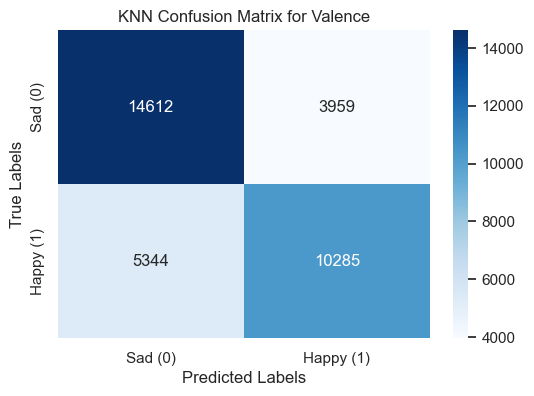

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(target_test, target_pred)

# Create the heatmap
plt.figure(figsize=(6, 4))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", ax=ax)

# Labels, title, and ticks
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("KNN Confusion Matrix for Valence")
ax.xaxis.set_ticklabels(["Sad (0)", "Happy (1)"])
ax.yaxis.set_ticklabels(["Sad (0)", "Happy (1)"])

plt.show()

In [100]:
# False positives
results = pd.DataFrame(X)  # make sure this matches your data

test_actual = attr_test  # Copy attr_test
test_actual["target_pred"] = target_pred  # Create new column for prediction values
test_actual["test_actual"] = target_test  # Create new column for actual values
# test_actual.head()  # Show table

false_positives = test_actual[
    (test_actual["target_pred"] == 1) & (test_actual["test_actual"] == 0)
]

false_negatives = test_actual[
    (test_actual["target_pred"] == 0) & (test_actual["test_actual"] == 1)
]

true_positives = test_actual[
    (test_actual["target_pred"] == 1) & (test_actual["test_actual"] == 1)
]

true_negatives = test_actual[
    (test_actual["target_pred"] == 0) & (test_actual["test_actual"] == 0)
]

print(false_positives)
print(false_negatives)
# false_positives.describe()

       danceability energy speechiness acousticness instrumentalness liveness  \
88580         0.786  0.696       0.352        0.183              0.0    0.123   
60735         0.911  0.616       0.272        0.569          0.00795    0.154   
20362         0.653  0.658      0.0304       0.0215         0.000002   0.0939   
37587         0.553  0.732       0.262        0.622              0.0    0.163   
7020          0.472  0.702      0.0981         0.82         0.000043    0.362   
...             ...    ...         ...          ...              ...      ...   
53279         0.578  0.854      0.0427      0.00823         0.000118   0.0815   
84333         0.653  0.472      0.0353       0.0554         0.000077    0.397   
103113        0.637  0.745      0.0748       0.0173         0.000554   0.0372   
53782         0.687  0.915      0.0411        0.021         0.000006    0.151   
41890         0.362  0.668      0.0432     0.000406           0.0094    0.131   

       popularity     tempo

In [101]:
# # Code given from the ML02_EDA.ipynb
# # Summarize each column
# summary_p = false_positives.describe().loc[["min", "max", "mean"]]
# summary_n = false_negatives.describe().loc[["min", "max", "mean"]]

# # Print the summary
# print(summary_p)
# print(summary_n)

# print("\n min, max, mean only")
# # Min_Max_Mean=df.describe(include=[float, int]).loc[["min", "max", "mean"]]
# Min_Max_Mean = X.describe(include=[float, int]).loc[["min", "max", "mean"]]
# print(Min_Max_Mean)

In [102]:
# print("False Negatives Summary vs Full Dataset:")
# print(false_negatives.describe().loc[["mean"]])
# print("\nFull Dataset:")
# print(df.describe().loc[["mean"]])

# delta_n = false_negatives.describe().loc["mean"] - df.describe().loc["mean"]
# print("\nDifference in Mean (False Negatives - Full Dataset):")
# print(delta_n)

# delta_p = false_positives.describe().loc["mean"] - df.describe().loc["mean"]
# print("\nDifference in Mean (False Positives - Full Dataset):")
# print(delta_p)

Index(['popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo'],
      dtype='object')


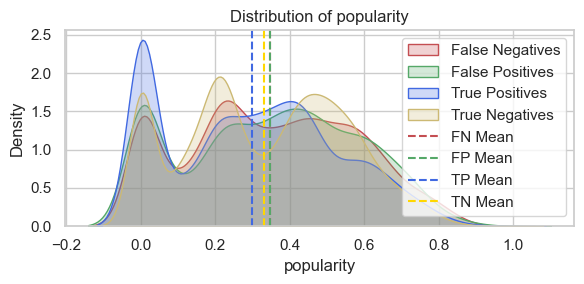

<class 'numpy.float64'>
Stats for 'popularity':
  False Negatives - mean: 0.3477, std: 0.2264
  False Positives - mean: 0.3472, std: 0.2321
  True Positives  - mean: 0.2982, std: 0.2257
  True Negatives  - mean: 0.3295, std: 0.2152
------------------------------------------------------------


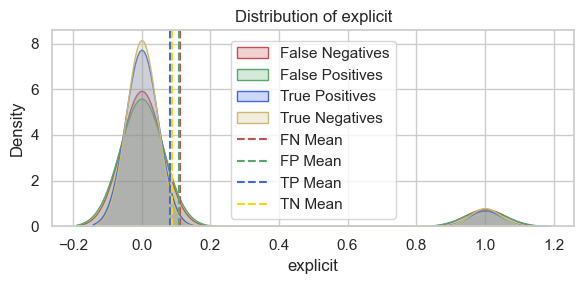

<class 'numpy.float64'>
Stats for 'explicit':
  False Negatives - mean: 0.1120, std: 0.3154
  False Positives - mean: 0.1097, std: 0.3126
  True Positives  - mean: 0.0817, std: 0.2740
  True Negatives  - mean: 0.0886, std: 0.2841
------------------------------------------------------------


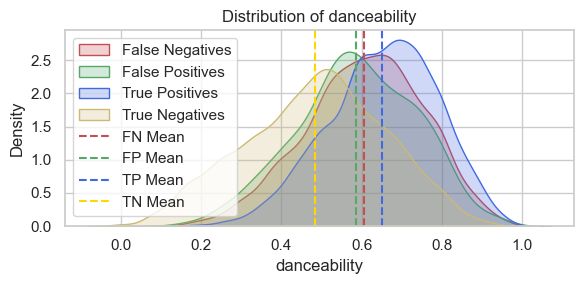

<class 'numpy.float64'>
Stats for 'danceability':
  False Negatives - mean: 0.6063, std: 0.1473
  False Positives - mean: 0.5864, std: 0.1513
  True Positives  - mean: 0.6519, std: 0.1369
  True Negatives  - mean: 0.4845, std: 0.1752
------------------------------------------------------------


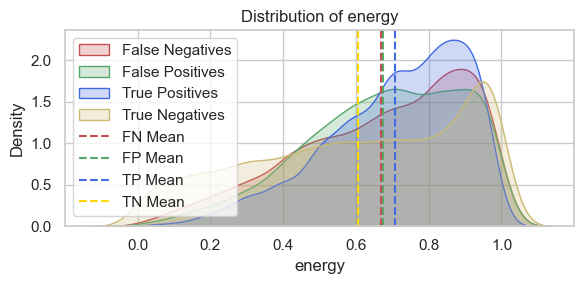

<class 'numpy.float64'>
Stats for 'energy':
  False Negatives - mean: 0.6692, std: 0.2315
  False Positives - mean: 0.6741, std: 0.2129
  True Positives  - mean: 0.7087, std: 0.1907
  True Negatives  - mean: 0.6057, std: 0.2890
------------------------------------------------------------


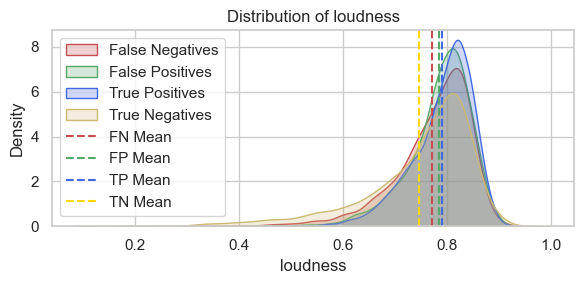

<class 'numpy.float64'>
Stats for 'loudness':
  False Negatives - mean: 0.7719, std: 0.0772
  False Positives - mean: 0.7844, std: 0.0641
  True Positives  - mean: 0.7904, std: 0.0610
  True Negatives  - mean: 0.7461, std: 0.1094
------------------------------------------------------------


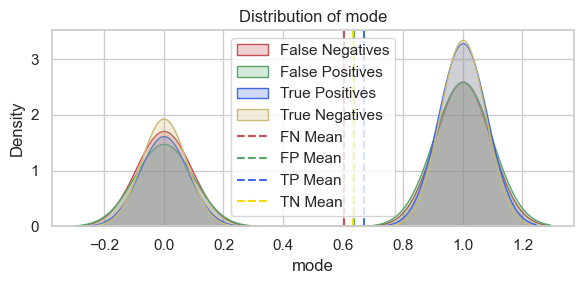

<class 'numpy.float64'>
Stats for 'mode':
  False Negatives - mean: 0.6023, std: 0.4895
  False Positives - mean: 0.6370, std: 0.4809
  True Positives  - mean: 0.6702, std: 0.4702
  True Negatives  - mean: 0.6338, std: 0.4818
------------------------------------------------------------


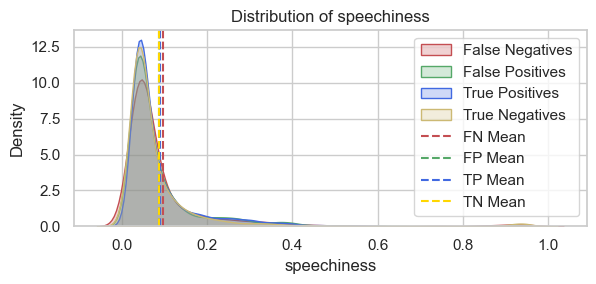

<class 'numpy.float64'>
Stats for 'speechiness':
  False Negatives - mean: 0.0962, std: 0.1325
  False Positives - mean: 0.0860, std: 0.0957
  True Positives  - mean: 0.0881, std: 0.0963
  True Negatives  - mean: 0.0869, std: 0.1253
------------------------------------------------------------


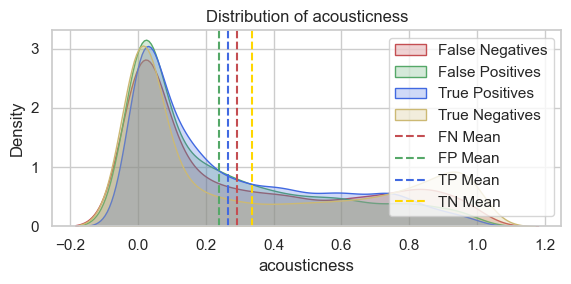

<class 'numpy.float64'>
Stats for 'acousticness':
  False Negatives - mean: 0.2931, std: 0.3230
  False Positives - mean: 0.2407, std: 0.2779
  True Positives  - mean: 0.2655, std: 0.2750
  True Negatives  - mean: 0.3367, std: 0.3685
------------------------------------------------------------


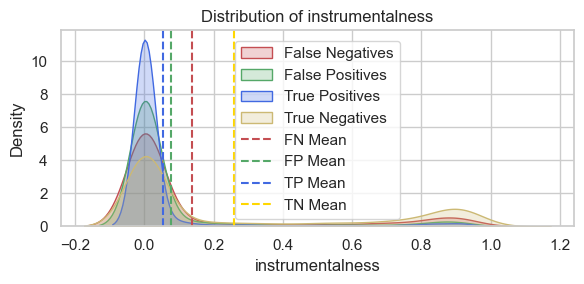

<class 'numpy.float64'>
Stats for 'instrumentalness':
  False Negatives - mean: 0.1386, std: 0.2897
  False Positives - mean: 0.0783, std: 0.2153
  True Positives  - mean: 0.0527, std: 0.1791
  True Negatives  - mean: 0.2595, std: 0.3701
------------------------------------------------------------


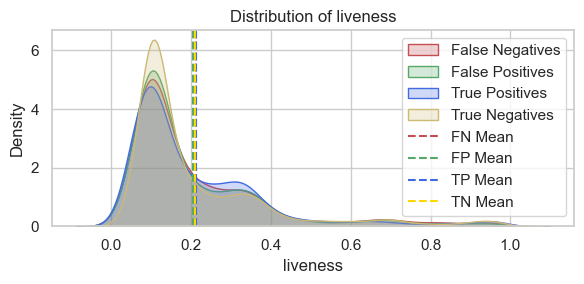

<class 'numpy.float64'>
Stats for 'liveness':
  False Negatives - mean: 0.2122, std: 0.1845
  False Positives - mean: 0.2054, std: 0.1772
  True Positives  - mean: 0.2121, std: 0.1834
  True Negatives  - mean: 0.2105, std: 0.1855
------------------------------------------------------------


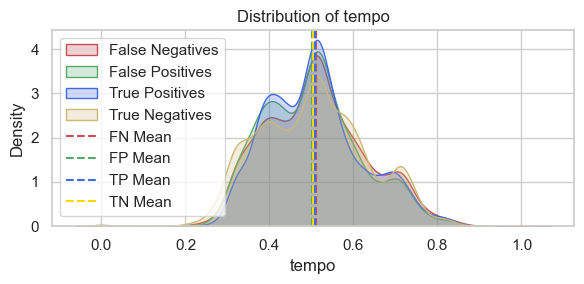

<class 'numpy.float64'>
Stats for 'tempo':
  False Negatives - mean: 0.5104, std: 0.1209
  False Positives - mean: 0.5005, std: 0.1152
  True Positives  - mean: 0.5073, std: 0.1142
  True Negatives  - mean: 0.5032, std: 0.1287
------------------------------------------------------------


In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

df_no_genres = df.loc[:, ~df.columns.str.contains("track_genre")]

feature_cols = [
    col
    for col in df_no_genres.columns
    if col
    not in [
        "target_actual",
        "target_pred",
        "track_id",
        "artists",
        "album_name",
        "track_name",
        "valence",
    ]
]

# KF_df = df.drop(columns=["valence","duration_ms"])
print(df_no_genres.select_dtypes(include=["float", "int"]).columns)
for col in df_no_genres.select_dtypes(include=["float", "int"]).columns:
    if col == "valence" or col == "duration_ms": continue
   
    plt.figure(figsize=(6, 3))

    # KDE plots
    sns.kdeplot(false_negatives[col], label="False Negatives", fill=True, color="r")
    sns.kdeplot(false_positives[col], label="False Positives", fill=True, color="g")
    sns.kdeplot(true_positives[col], label="True Positives", fill=True, color="royalblue")
    sns.kdeplot(true_negatives[col], label="True Negatives", fill=True, color="y")

    # Vertical lines for means
    plt.axvline(false_negatives[col].mean(), color="r", linestyle="--", label="FN Mean")
    plt.axvline(false_positives[col].mean(), color="g", linestyle="--", label="FP Mean")
    plt.axvline(
        true_positives[col].mean(), color="royalblue", linestyle="--", label="TP Mean"
    )
    plt.axvline(
        true_negatives[col].mean(), color="gold", linestyle="--", label="TN Mean"
    )

    plt.title(f"Distribution of {col}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(type(false_negatives[col].mean()))

    print(f"Stats for '{col}':")
    print(f"  False Negatives - mean: {false_negatives[col].mean():.4f}, std: {false_negatives[col].std():.4f}")
    print(f"  False Positives - mean: {false_positives[col].mean():.4f}, std: {false_positives[col].std():.4f}")
    print(f"  True Positives  - mean: {true_positives[col].mean():.4f}, std: {true_positives[col].std():.4f}")
    print(f"  True Negatives  - mean: {true_negatives[col].mean():.4f}, std: {true_negatives[col].std():.4f}")
    print("-" * 60)

['popularity', 'explicit', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'time_signature_1', 'time_signature_3', 'time_signature_4', 'time_signature_5']
------------------------------------------------------------
1) Heatmap of feature means per outcome
------------------------------------------------------------


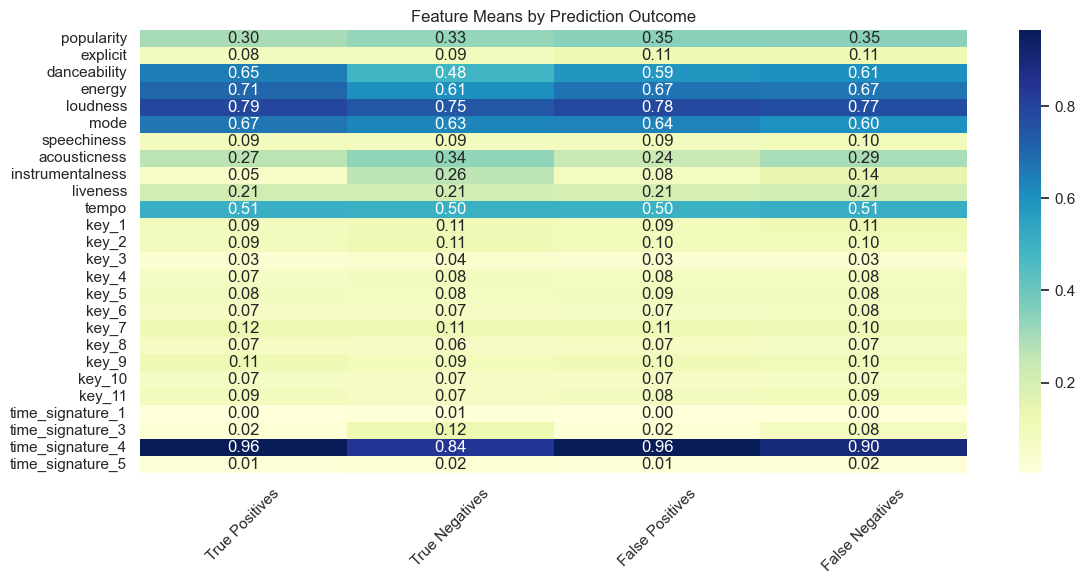

------------------------------------------------------------
2) Bar Plots of each feature
------------------------------------------------------------
instrumentalness std deviation:  0.09214853002930391


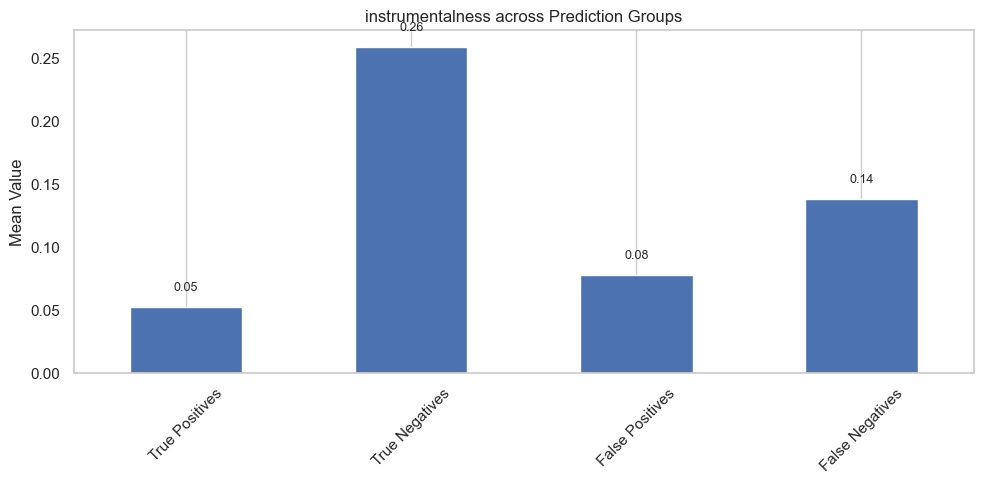

danceability std deviation:  0.07072429453632618


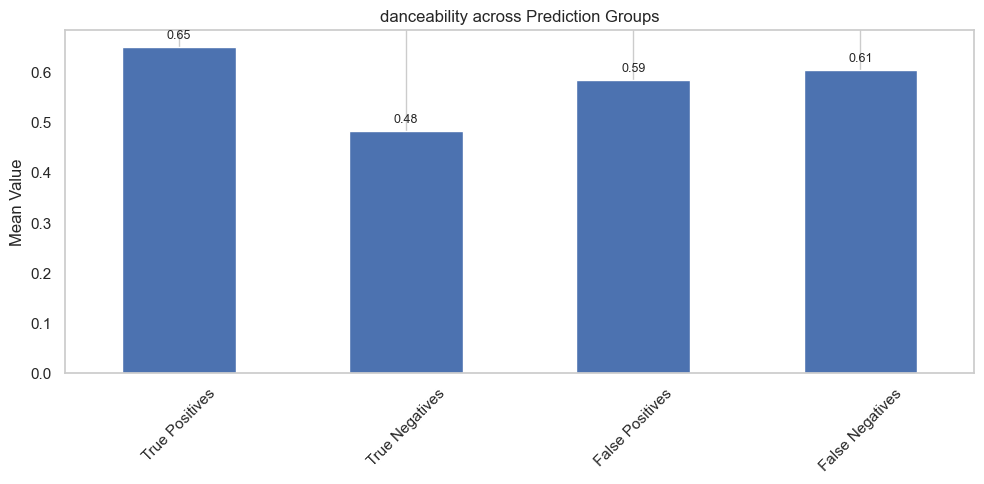

time_signature_4 std deviation:  0.06023379316752906


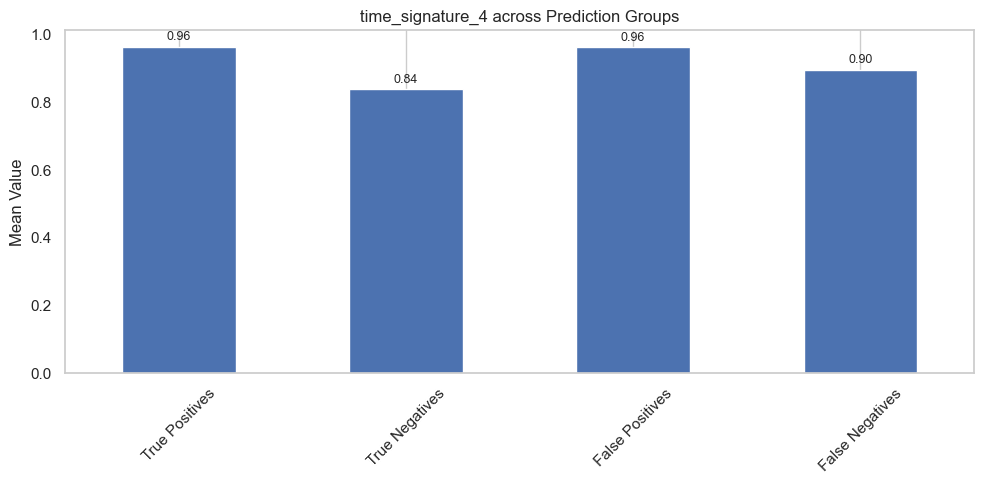

time_signature_3 std deviation:  0.0503297353905897


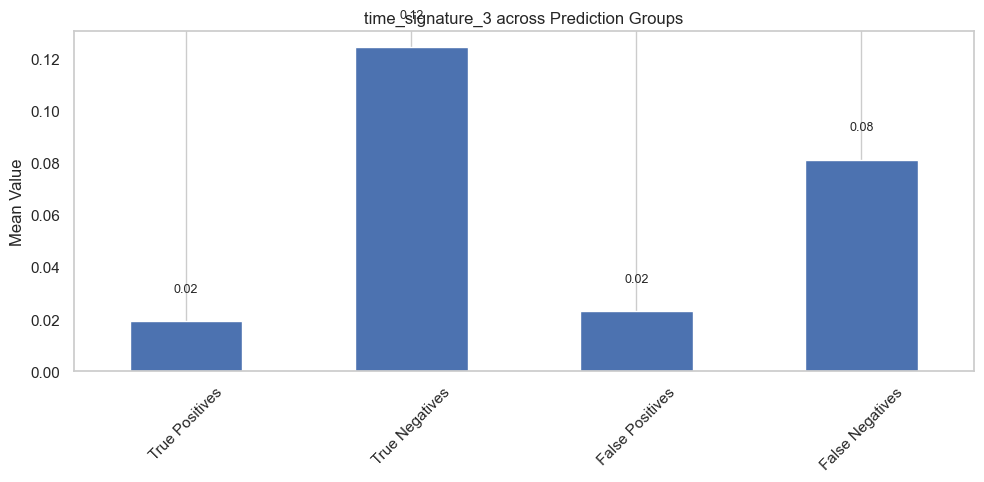

energy std deviation:  0.042908543484336974


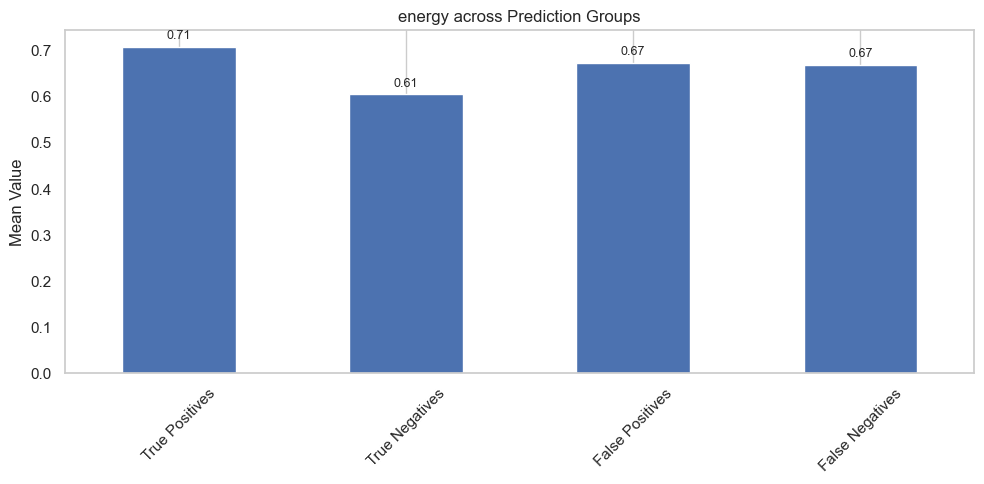

acousticness std deviation:  0.04113528307799


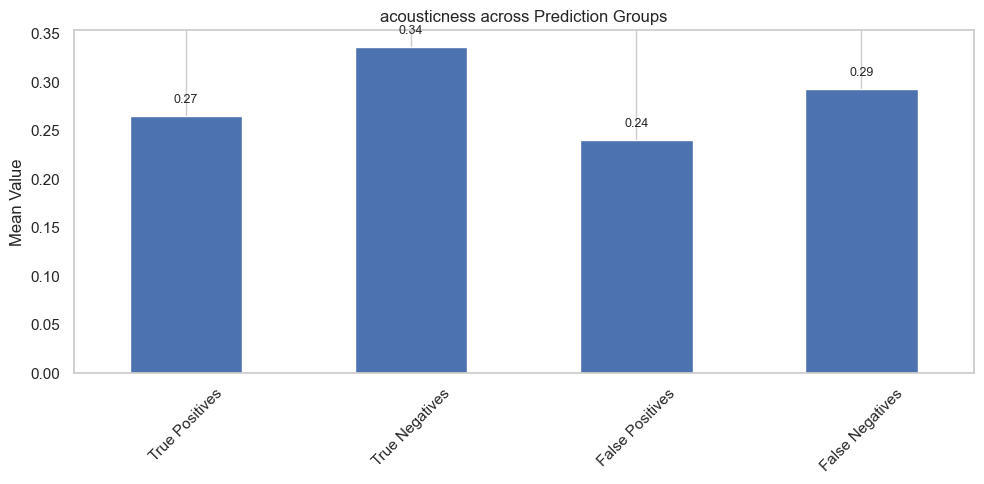

mode std deviation:  0.027765470893364244


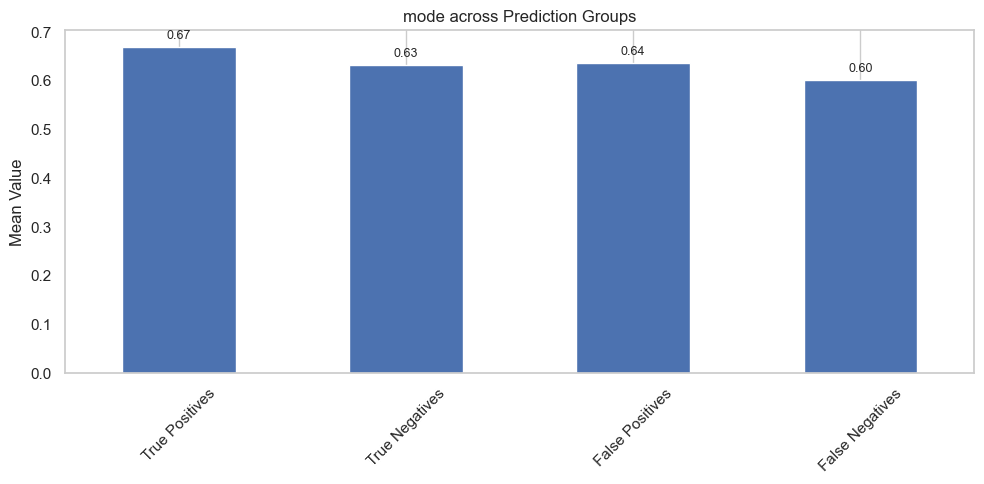

popularity std deviation:  0.02324478017783087


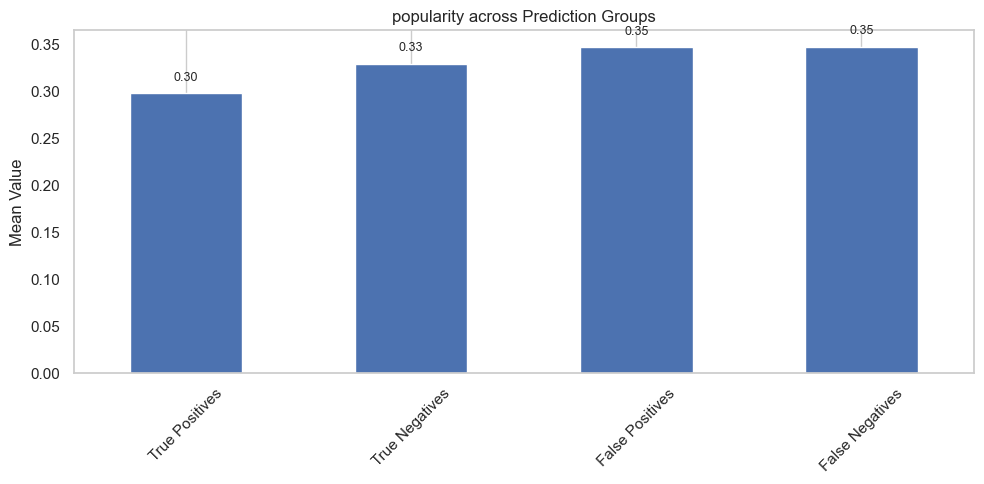

loudness std deviation:  0.019649681945681993


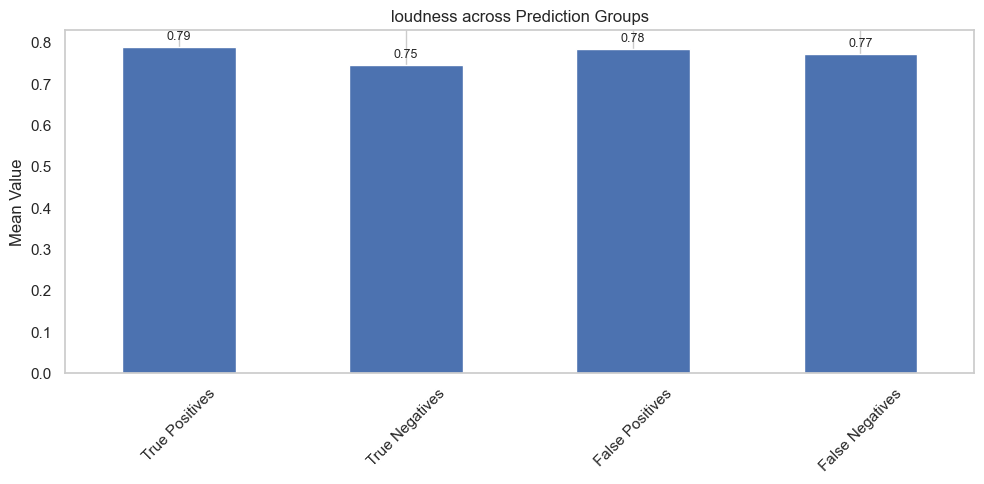

explicit std deviation:  0.015117478634560859


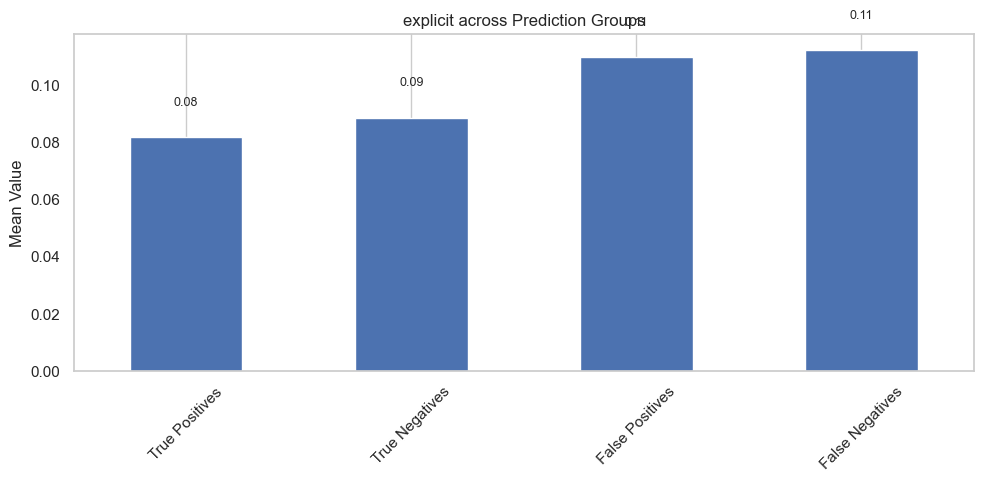

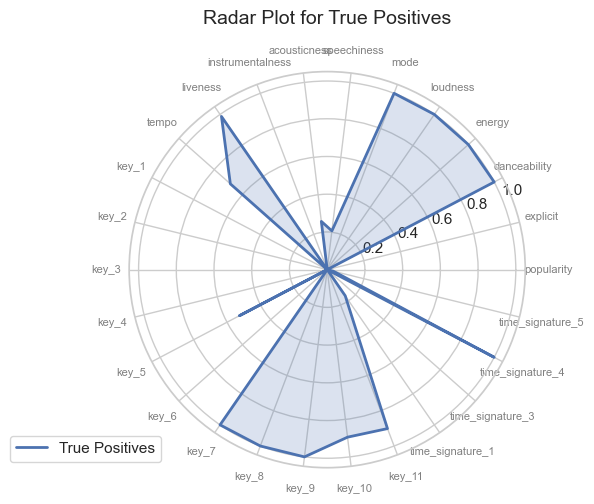

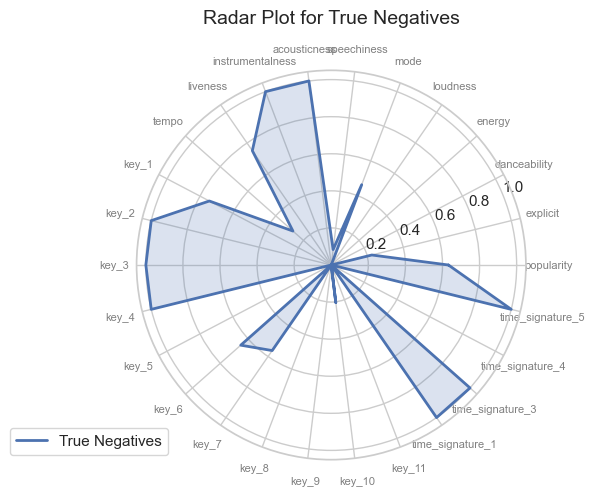

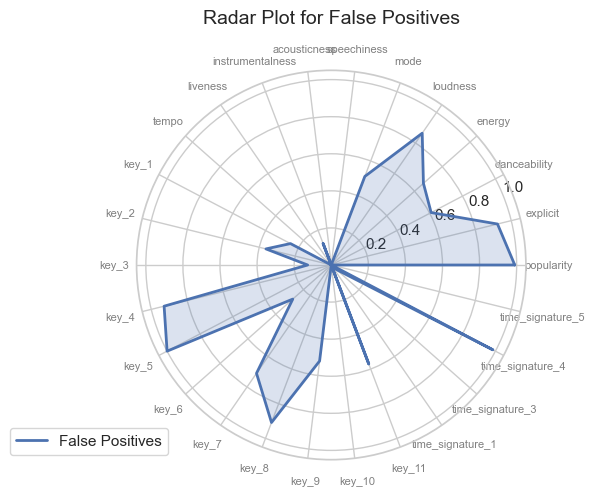

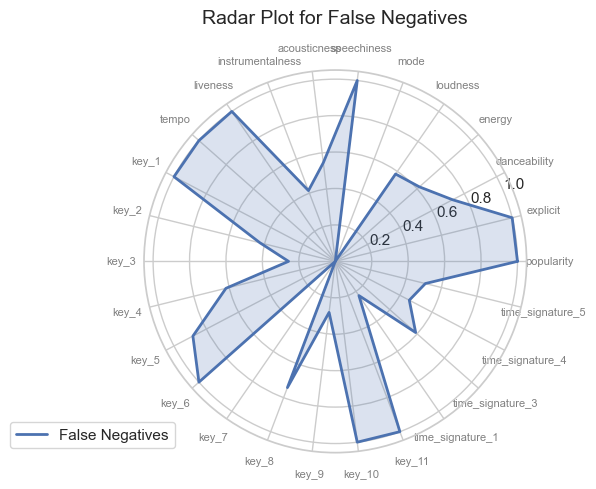

In [111]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

df_no_genres = df.loc[:, ~df.columns.str.contains("track_genre")]

# Features only (adjust as needed)
feature_cols = [
    col
    for col in df_no_genres.columns
    if col
    not in [
        "target_actual",
        "target_pred",
        "track_id",
        "artists",
        "album_name",
        "track_name",
        "valence",
        "duration_ms"
    ]
]

print(feature_cols)

# Mean summary per category
summary_df = pd.DataFrame(
    {
        "True Positives": true_positives[feature_cols].mean(),
        "True Negatives": true_negatives[feature_cols].mean(),
        "False Positives": false_positives[feature_cols].mean(),
        "False Negatives": false_negatives[feature_cols].mean(),
        # "All Data": df[feature_cols].mean(),
    }
)

# Transpose for easier plotting
summary_df = summary_df.astype(float)
summary_df = summary_df.T

# Optional: Normalize columns for radar/spider-style plots
summary_norm = (summary_df - summary_df.min()) / (summary_df.max() - summary_df.min())

# --- Plot 1: Heatmap of Means per Outcome Type ---
print("-" * 60)
print("1) Heatmap of feature means per outcome")
print("-" * 60)

plt.figure(figsize=(12, 6))
sns.heatmap(summary_df.T, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Feature Means by Prediction Outcome")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Plot 2: Comparison Bar Plot for One Feature at a Time ---
# Choose top 5 most differing features (by std deviation across groups)
print("-" * 60)
print("2) Bar Plots of each feature")
print("-" * 60)

top_diff_features = summary_df.std().sort_values(ascending=False).head(10).index

for feature in top_diff_features:
    print(feature + ' std deviation: ', summary_df[feature].std())
    
    ax = summary_df[feature].plot(
        kind="bar", title=f"{feature} across Prediction Groups", ylabel="Mean Value"
    )

    # Add value labels above each bar
    for i, value in enumerate(summary_df[feature]):
        ax.text(i, value + 0.01, f"{value:.2f}", ha="center", va="bottom", fontsize=9)
        
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

# --- Plot 3: Radar Plot (optional, fancier) ---
try:
    from math import pi

    categories = list(summary_norm.columns)
    groups = summary_norm.index

    for group in groups:
        values = summary_norm.loc[group].tolist()
        values += values[:1]  # repeat the first value to close the circle

        angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
        angles += angles[:1]

        plt.figure(figsize=(6, 6))
        ax = plt.subplot(111, polar=True)
        plt.xticks(angles[:-1], categories, color="grey", size=8)

        ax.plot(angles, values, linewidth=2, linestyle="solid", label=group)
        ax.fill(angles, values, alpha=0.2)

        plt.title(f"Radar Plot for {group}", size=14, y=1.1)
        plt.legend(loc="upper right", bbox_to_anchor=(0.1, 0.1))
        plt.tight_layout()
        plt.show()
except ImportError:
    print("Radar plot skipped (requires polar plotting support).")

pop-film     59.283000
k-pop        56.952953
chill        53.651000
sad          52.379000
grunge       49.594000
indian       49.539000
anime        48.772000
emo          48.128000
sertanejo    47.866000
pop          47.576000

["pop-film", "k-pop", "chill", "sad", "grunge", "indian", "anime", "emo", "sertanejo", "pop"]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: prettier style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# --- Genre Counts per Prediction Outcome ---

# Ensure genre columns are all 0 or 1
genre_cols = [col for col in df.columns if col.startswith("track_genre")]


# Define the prediction outcome groups
groups = {
    "True Positives (H)": true_positives,
    "True Negatives (S)": true_negatives,
    "False Positives": false_positives,
    "False Negatives": false_negatives,
}


# Count genres per group
genre_counts = {
    group_name: (group_df[genre_cols]).astype(int).sum() for group_name, group_df in groups.items()
}


# Create a DataFrame
genre_counts_df = pd.DataFrame(genre_counts).T  # Outcomes as rows
# genre_counts_df.to_csv('output.csv', index=False)

top_10_popular_genres = ["track_genre_pop-film", "track_genre_k-pop", "track_genre_chill", "track_genre_sad", "track_genre_grunge", "track_genre_indian", "track_genre_anime", "track_genre_emo", "track_genre_sertanejo", "pop"]
top_genres = genre_counts_df.sum(axis=0).sort_values(ascending=False).index
# top_genres = genre_counts_df.sum(axis=0).sort_values(ascending=False).head(20).index


# Plot barplot for each genre
for genre in top_genres:
    if genre not in top_10_popular_genres: 
        print(genre)
        continue
    
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(
        x=genre_counts_df.index,
        y=genre_counts_df[genre].values,
        hue=["True Positive", "True Negative", "False Positive", "False Negative"],
        palette=["green", "red", "lightgreen", "lightcoral"],
    )

    # Add value labels above bars
    for i, value in enumerate(genre_counts_df[genre].values):
        ax.text(i, value + 0.5, str(int(value)), ha="center", va="bottom", fontsize=9)

    plt.title(f"Counts of {genre} by Prediction Outcome")
    plt.ylabel("Number of Tracks")
    plt.xlabel("Prediction Outcome")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(genre_counts_df[genre])

track_genre_idm
track_genre_grindcore
track_genre_house
track_genre_goth
track_genre_jazz
track_genre_blues
track_genre_j-pop
track_genre_black-metal
track_genre_indie
track_genre_british
track_genre_funk
track_genre_dubstep
track_genre_j-dance
track_genre_groove
track_genre_alt-rock
track_genre_electronic
track_genre_dancehall
track_genre_grunge
track_genre_industrial
track_genre_country
track_genre_folk
track_genre_emo
track_genre_german
track_genre_electro
track_genre_garage
track_genre_french
track_genre_honky-tonk
track_genre_children
track_genre_forro
track_genre_drum-and-bass
track_genre_dub
track_genre_classical
track_genre_hardstyle
track_genre_cantopop
track_genre_bluegrass
track_genre_edm
track_genre_disney
track_genre_hardcore
track_genre_j-rock
track_genre_j-idol
track_genre_detroit-techno
track_genre_afrobeat
track_genre_dance
track_genre_happy
track_genre_club
track_genre_hip-hop
track_genre_indian
track_genre_chicago-house
track_genre_indie-pop
track_genre_hard-rock
tra

In [106]:
# Count of genres in true positives
# print(true_negatives.columns.values)
# genre_columns = [col for col in df.columns if col.startswith("track_genre_")]
# print(genre_columns)

# # Step 2: Use idxmax to get the column name with value 1
# df["track_genre"] = df[genre_columns].idxmax(axis=1)

# # Step 3: Remove the "track_genre_" prefix
# df["track_genre"] = df["track_genre"].str.replace("track_genre_", "")

# # Optional: Drop one-hot columns
# df = df.drop(columns=genre_columns)

# mood_counts_by_genre = (
#     df.groupby("track_genre")["valence"].value_counts().unstack().fillna(0)
# )
# true_negatives.to_csv("true_negatives.csv", index=False)

In [107]:
# Count of genres in true positives
# print(true_negatives.columns.values)
# genre_columns = [col for col in df.columns if col.startswith("track_genre_")]
# print(genre_columns)

# # Step 2: Use idxmax to get the column name with value 1
# df["track_genre"] = df[genre_columns].idxmax(axis=1)

# # Step 3: Remove the "track_genre_" prefix
# df["track_genre"] = df["track_genre"].str.replace("track_genre_", "")

# # Optional: Drop one-hot columns
# df = df.drop(columns=genre_columns)

# mood_counts_by_genre = (
#     df.groupby("track_genre")["valence"].value_counts().unstack().fillna(0)
# )
# true_negatives.to_csv("true_negatives.csv", index=False)

In [108]:
# sns.set(style="whitegrid")
# plt.rcParams["figure.figsize"] = (10, 5)

# # df_no_genres = df.loc[:, ~df.columns.str.contains("track_genre")]

# # Features only (adjust as needed)
# feature_cols = [
#     col
#     for col in df.columns
#     if col
#     not in [
#         "target_actual",
#         "target_pred",
#         "track_id",
#         "artists",
#         "album_name",
#         "track_name",
#         "valence",
#     ]
# ]

# print(feature_cols)

# # Mean summary per category
# summary_df = pd.DataFrame(
#     {
#         "False Negatives": false_negatives[feature_cols].mean(),
#         "False Positives": false_positives[feature_cols].mean(),
#         "True Positives": true_positives[feature_cols].mean(),
#         "True Negatives": true_negatives[feature_cols].mean(),
#         # "All Data": df[feature_cols].mean(),
#     }
# )

# # Transpose for easier plotting
# summary_df = summary_df.T

# # Optional: Normalize columns for radar/spider-style plots
# summary_norm = (summary_df - summary_df.min()) / (summary_df.max() - summary_df.min())


# # --- Comparison Bar Plot for of each genre  ---
# # Choose top 10 most differing features that are ONLY GENRES (by std deviation across groups)
# top_diff_features = (
#     summary_df.filter(like="track_genre")
#     .std()
#     .sort_values(ascending=False)
#     # .head(10)
#     .index
# )


# for feature in top_diff_features:
#     summary_df[feature].plot(
#         kind="bar", title=f"{feature} across Prediction Groups", ylabel="Mean Value"
#     )
#     plt.xticks(rotation=45)
#     plt.grid(axis="y")
#     plt.tight_layout()
#     plt.show()

# # --- Radar Plot (optional, fancier) ---
# try:
#     from math import pi

#     categories = list(summary_norm.columns)
#     groups = summary_norm.index

#     for group in groups:
#         values = summary_norm.loc[group].tolist()
#         values += values[:1]  # repeat the first value to close the circle

#         angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
#         angles += angles[:1]

#         plt.figure(figsize=(6, 6))
#         ax = plt.subplot(111, polar=True)
#         plt.xticks(angles[:-1], categories, color="grey", size=8)

#         ax.plot(angles, values, linewidth=2, linestyle="solid", label=group)
#         ax.fill(angles, values, alpha=0.2)

#         plt.title(f"Radar Plot for {group}", size=14, y=1.1)
#         plt.legend(loc="upper right", bbox_to_anchor=(0.1, 0.1))
#         plt.tight_layout()
#         plt.show()
# except ImportError:
#     print("Radar plot skipped (requires polar plotting support).")

Using K-Nearest Neighbors with audio features to predict song valence, our model achieved a classification accuracy of 73.6%. The model performs slightly better at identifying low-valence (sadder) songs, with higher recall (79%) compared to high-valence (happier) songs (67%). Precision is fairly balanced across both classes. The findings suggest that features like danceability, energy, and acousticness have predictive value for estimating a song’s mood, but future work could explore better handling of class imbalance or using more sophisticated models to improve recall for high-valence tracks.